In [1]:
import numpy as np
import pandas as pd
import nltk
from sklearn.naive_bayes import MultinomialNB , GaussianNB
from sklearn.metrics import accuracy_score

In [2]:
data = pd.read_csv('yelp_labelled.csv' , sep = "/t")

C:\Users\Mishi\anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [3]:
data.head()

,"review sentiment,,,,"
0,"""Wow... Loved this place.\t1"",,,,"
1,"""Crust is not good.\t0"",,,,"
2,"""Not tasty and the texture was just nasty.\t0""..."
3,"""Stopped by during the late May bank holiday o..."
4,"""The selection on the menu was great and so we..."


In [4]:
type(data)

pandas.core.frame.DataFrame

In [5]:
data.columns = ['review']

In [6]:
data.head()

,review
0,"""Wow... Loved this place.\t1"",,,,"
1,"""Crust is not good.\t0"",,,,"
2,"""Not tasty and the texture was just nasty.\t0""..."
3,"""Stopped by during the late May bank holiday o..."
4,"""The selection on the menu was great and so we..."


In [7]:
data['sentiment'] = [int(i.strip('""').strip(",,,").split("\t")[1].strip('"')[0]) for i in data.review]
data.review = [i.strip('""').strip(",,,").split("\t")[0] for i in data.review]  

In [8]:
data.head()

,review,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


## data visualization

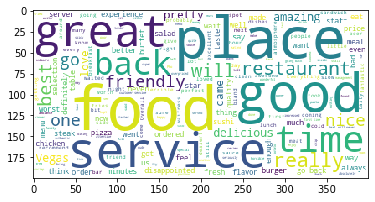

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
input_string = ' '.join(data.review)

wc = WordCloud(background_color ='white').generate(input_string)
plt.imshow(wc)


### Data Cleaning

In [10]:
stopwords = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.PorterStemmer()
docs = data['review'].str.lower().str.replace('[^a-z ]', '')
def clean_sentence(text):
    words = text.split(' ')
    words_clean = [stemmer.stem(word) for word in words if word not in stopwords]
    return ' '.join(words_clean)
docs_clean = docs.apply(clean_sentence)
docs_clean.head()

0                                       wow love place
1                                           crust good
2                                   tasti textur nasti
3    stop late may bank holiday rick steve recommen...
4                              select menu great price
Name: review, dtype: object

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
vectorize = CountVectorizer(min_df =5)
vectorize.fit(docs_clean)
dtm = vectorize.transform(docs_clean)
dtm

<1000x273 sparse matrix of type '<class 'numpy.int64'>'
	with 3468 stored elements in Compressed Sparse Row format>

In [12]:
df_dtm = pd.DataFrame(dtm.toarray() , columns = vectorize.get_feature_names())

In [13]:
from sklearn.model_selection import train_test_split
train_x, test_x = train_test_split(df_dtm , test_size = 0.2, random_state =100)
test_y = data.iloc[test_x.index]['sentiment']
train_y = data.loc[train_x.index]['sentiment']

### Using Multinomial Naïve Bayes, create a supervised model to predict the sentiment and report accuracy 

In [14]:
from sklearn.naive_bayes import MultinomialNB , GaussianNB
from sklearn.metrics import accuracy_score
mnb_model = MultinomialNB()
gnb_model = GaussianNB()
mnb_model.fit(train_x , train_y)
mnb_predict_class = mnb_model.predict(test_x)
print(accuracy_score(test_y ,mnb_predict_class) ,'multinomial')
gnb_model.fit(train_x , train_y)
gnb_predict_class = gnb_model.predict(test_x)
print(accuracy_score(test_y ,gnb_predict_class) ,'gausian')

0.79 multinomial
0.705 gausian


### Using Adaboost and Random Forest to create a supervised model to predict the sentiment and report 

In [15]:
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier
model_rf=RandomForestClassifier(random_state=100,n_estimators=300 ,criterion= 'gini', max_depth = 19)
model_rf.fit(train_x,train_y)
pred=model_rf.predict(test_x)
print('Random Forest Classifier',accuracy_score(test_y,pred))


Random Forest Classifier 0.745


In [16]:
model3 = AdaBoostClassifier(random_state =100, n_estimators= 300)
model3.fit(train_x,train_y)
pred=model3.predict(test_x)
print('AdaBoost Classifer',accuracy_score(test_y,pred))

AdaBoost Classifer 0.76


Accuracy: 0.76
              precision    recall  f1-score   support

           0       0.73      0.77      0.75        94
           1       0.78      0.75      0.77       106

    accuracy                           0.76       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.76      0.76      0.76       200



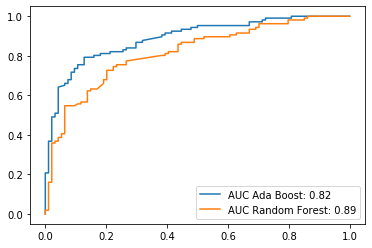

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score , classification_report, confusion_matrix
%matplotlib inline

model3 = AdaBoostClassifier(random_state =100, n_estimators= 300)
model3.fit(train_x,train_y)
pred=model3.predict(test_x)
pred_probs = pd.DataFrame(model3.predict_proba(test_x),  columns=['Neg', 'Pos'])
print('Accuracy: %.2f' % accuracy_score(test_y, pred))
print(classification_report(test_y, pred))



fpr_knn, tpr_knn, thresholds = roc_curve(test_y, pred_probs['Pos'])
auc_knn = auc(fpr_knn, tpr_knn)


model_rf = RandomForestClassifier(random_state=100, n_estimators=300)
model_rf.fit(train_x, train_y)
pred_probs_rf = pd.DataFrame(model_rf.predict_proba(test_x),
                             columns=['Neg', 'Pos'])

fpr_rf_300, tpr_rf_300, thr_rf_300 = roc_curve(test_y,pred_probs_rf['Pos'])
auc_rf = auc(fpr_rf_300, tpr_rf_300)
plt.plot(fpr_rf_300, tpr_rf_300)
plt.plot(fpr_knn, tpr_knn)
plt.legend(['AUC Ada Boost: %.2f' % auc_knn ,'AUC Random Forest: %.2f' % auc_rf])
#plt.legend(['AUC Random Forest: %.2f' % auc_rf])

### Google vec to word

In [18]:
%%html
<a href="https://www.kaggle.com/gangwareshita/assignment-2">Kaggle Link</a>

In [30]:
!pip install gensim

## Vader

In [22]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment = SentimentIntensityAnalyzer();

In [23]:
def get_sentiment(text):
    compound = sentiment.polarity_scores(text)['compound']
    if compound < 0:
        return 0
    else:
        return 1
data['sentiment_vader'] = data['review'].apply(get_sentiment)

In [24]:
from sklearn.metrics import accuracy_score
accuracy_score(data['sentiment'], data['sentiment_vader'])

0.717

#### Apply topic modelling to understand the topics discussed in the reviews. Using multiple iterations, choose appropriate number of topics. Visualize number of documents under each cluster using a bar chart 

In [25]:
type(data['review'].fillna('').str.lower())

pandas.core.series.Series

In [26]:
docs = data['review'].fillna('').str.lower()
docs = docs.str.replace('[^a-z ]','')

                        
# We check for stopswords both before and after stemming because after stemming
#some words will be abbreviated in a way such that they become like normal words
                        
docs_clean = []
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['', 'use','like','work','one'])
stemmer = nltk.stem.PorterStemmer()
for doc in docs:
                        words = doc.split(' ')
                        words_clean = [stemmer.stem(word) for word in words if word not in stopwords]
                        docs_clean.append(words_clean)

In [31]:
import gensim
dictionary = gensim.corpora.Dictionary(docs_clean)

In [32]:
docs_bow = []
for doc in docs_clean:
    bow = dictionary.doc2bow(doc)
    docs_bow.append(bow)

In [33]:
lda_model = gensim.models.LdaModel(docs_bow,id2word =dictionary, num_topics = 4)

In [34]:
lda_model.get_document_topics(docs_bow[0])

[(0, 0.06363219), (1, 0.06698615), (2, 0.06478144), (3, 0.8046002)]

In [35]:
topics = []
for bow in docs_bow:
    doc2topic = pd.DataFrame(lda_model.get_document_topics(docs_bow[0]), columns=['topic_no', 'prob'])
    topic = doc2topic.sort_values('prob', ascending=False)
    topic = topic.iloc[0]['topic_no']
    topics.append(topic)

In [36]:
lda_model.print_topics()

[(0,
  '0.029*"food" + 0.011*"place" + 0.010*"restaur" + 0.010*"servic" + 0.009*"would" + 0.008*"great" + 0.008*"go" + 0.007*"order" + 0.006*"best" + 0.006*"star"'),
 (1,
  '0.023*"place" + 0.013*"servic" + 0.011*"get" + 0.010*"great" + 0.008*"food" + 0.006*"go" + 0.006*"friendli" + 0.006*"best" + 0.006*"back" + 0.005*"amaz"'),
 (2,
  '0.020*"food" + 0.020*"back" + 0.015*"good" + 0.013*"go" + 0.009*"time" + 0.009*"servic" + 0.008*"nice" + 0.007*"wait" + 0.006*"realli" + 0.006*"minut"'),
 (3,
  '0.028*"good" + 0.026*"place" + 0.016*"great" + 0.016*"servic" + 0.012*"time" + 0.011*"food" + 0.010*"love" + 0.008*"disappoint" + 0.007*"go" + 0.007*"back"')]

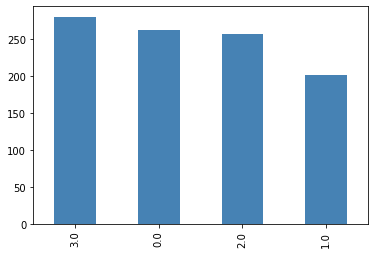

In [37]:
topics = []
for doc_bow in docs_bow:
    doc2topic_prob = lda_model.get_document_topics(doc_bow)
    doc2topic_prob= pd.DataFrame(doc2topic_prob,columns = ['topic','prob'])
    topic = doc2topic_prob.sort_values('prob',ascending=False).iloc[0]['topic']
    topics.append(topic)
    
data['topics']=topics
data['topics'].value_counts().plot.bar(color='steelblue')

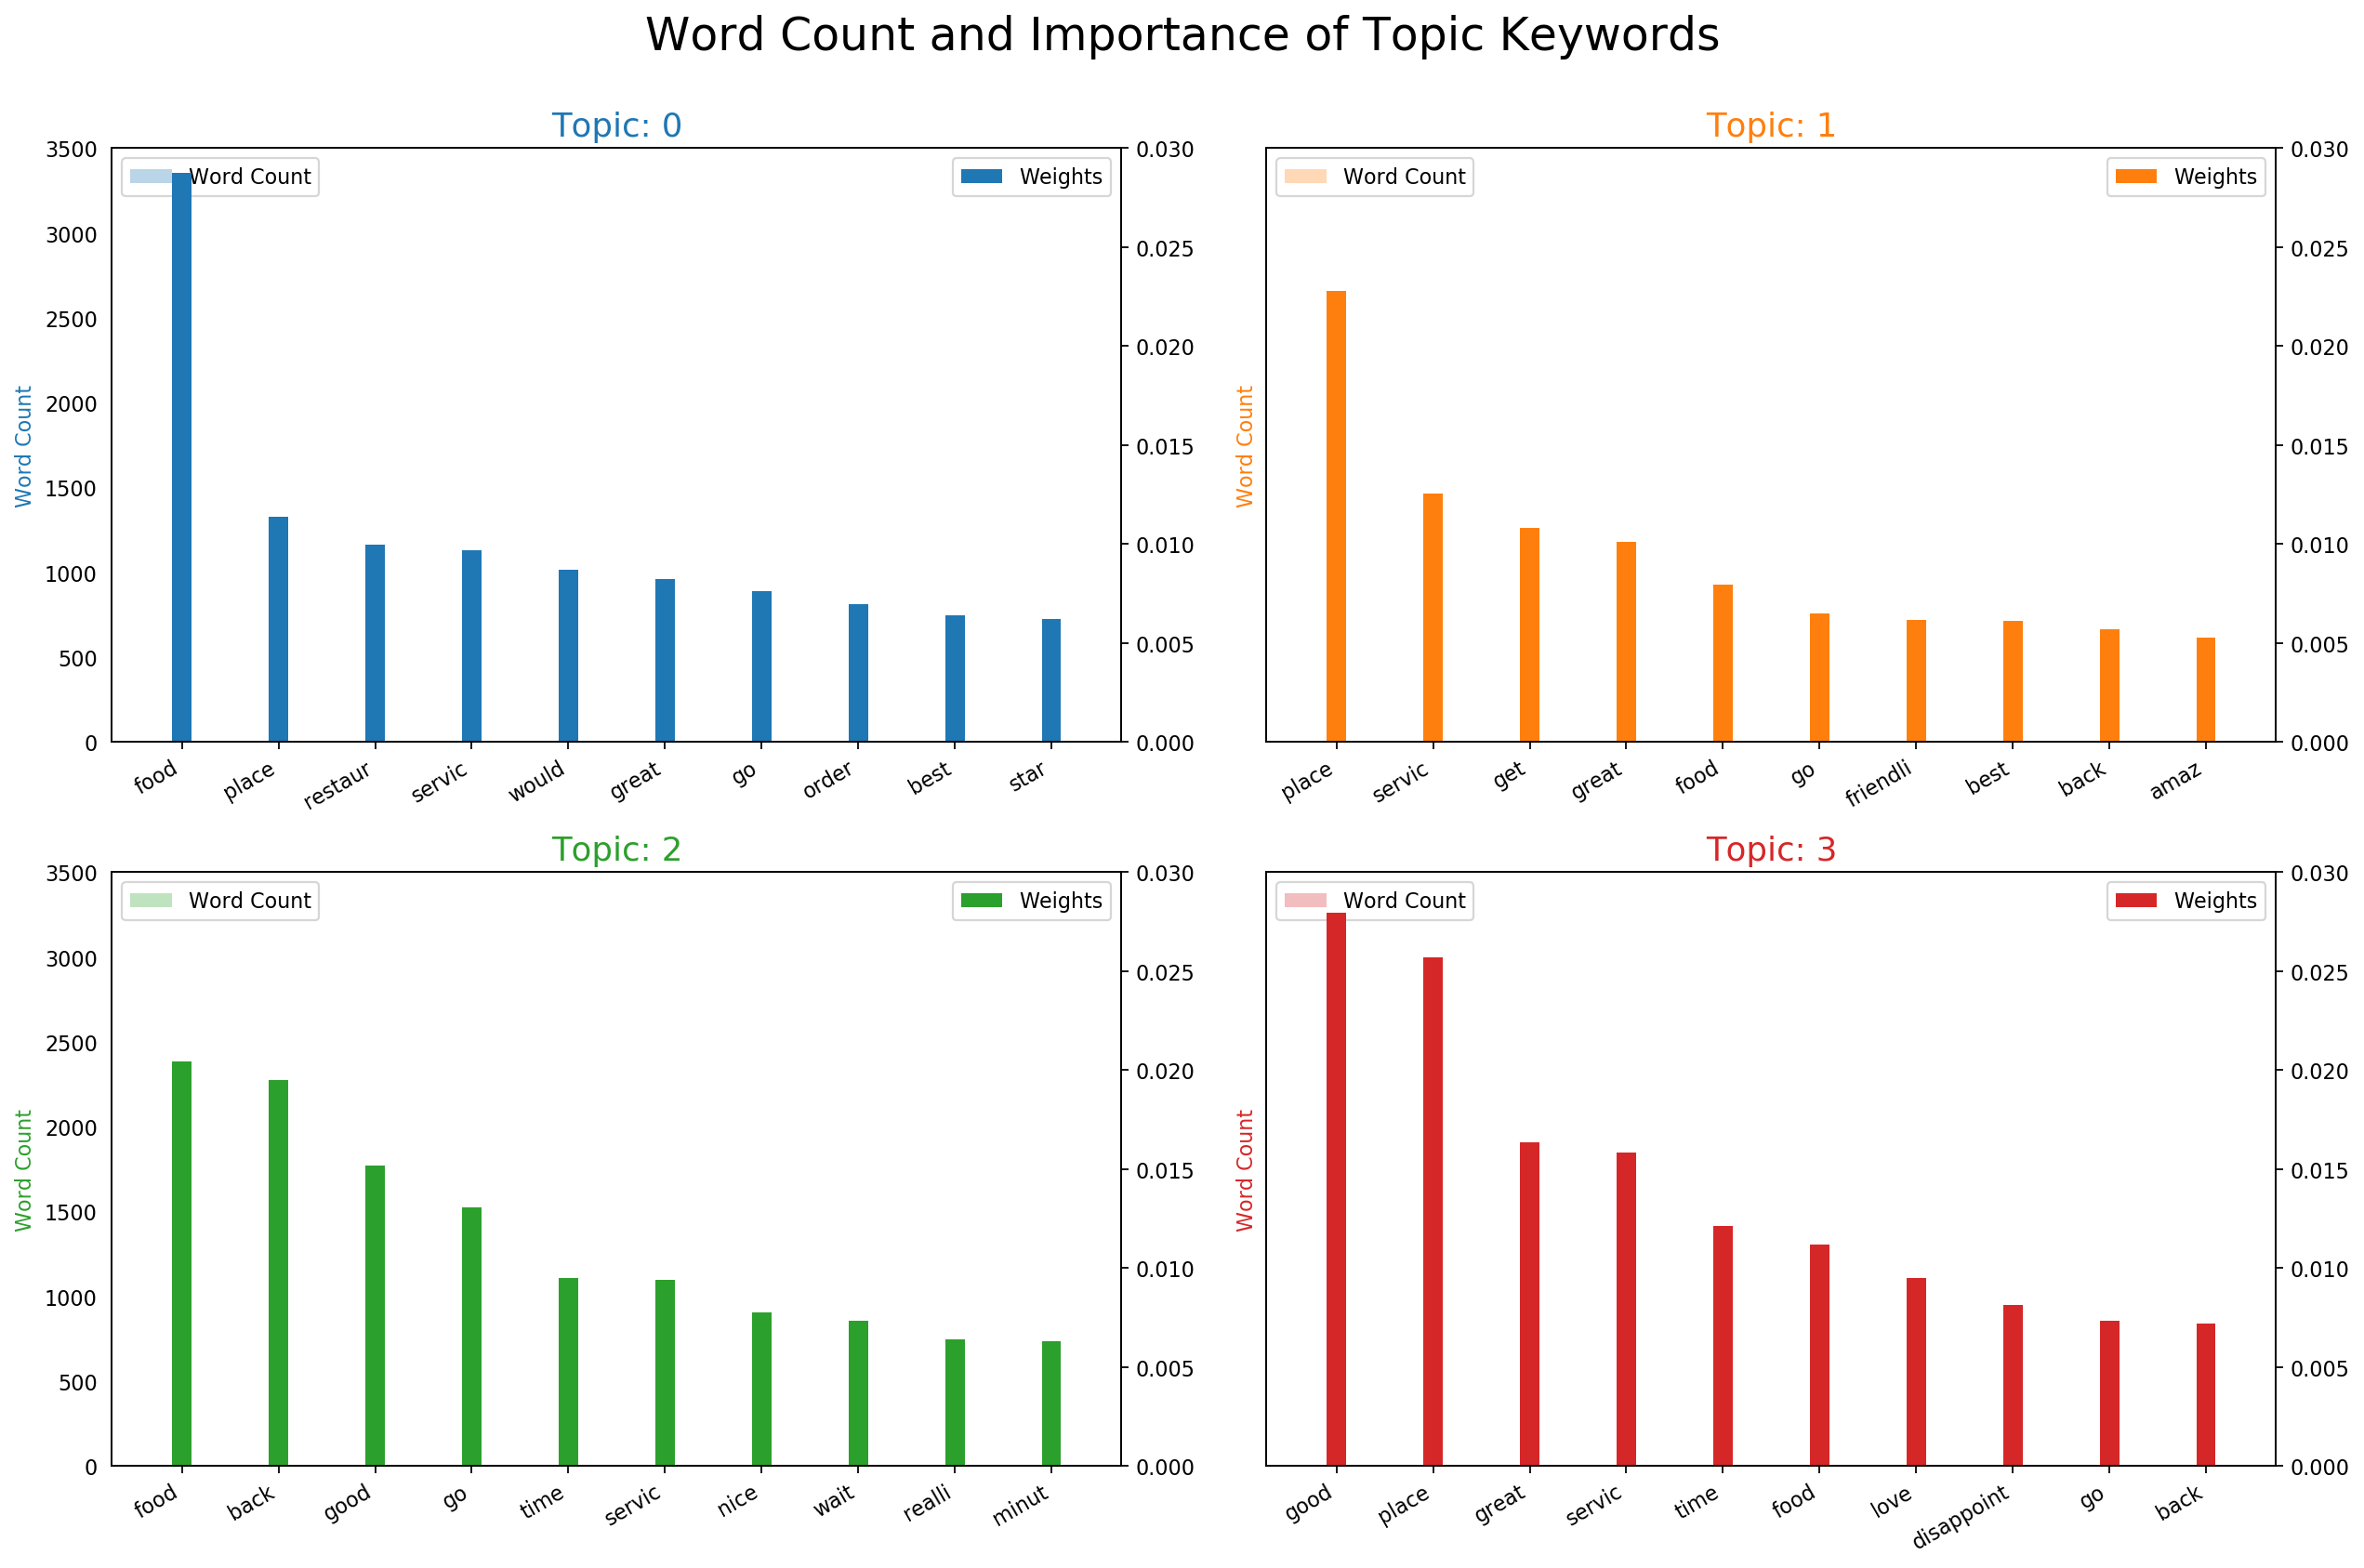

In [38]:
import matplotlib.colors as mcolors
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()


<built-in method keys of dict object at 0x00000225EE36E4F8>
<built-in method keys of dict object at 0x00000225F29D0DB8>
<built-in method keys of dict object at 0x00000225F29D0868>
<built-in method keys of dict object at 0x00000225F2A0C3B8>


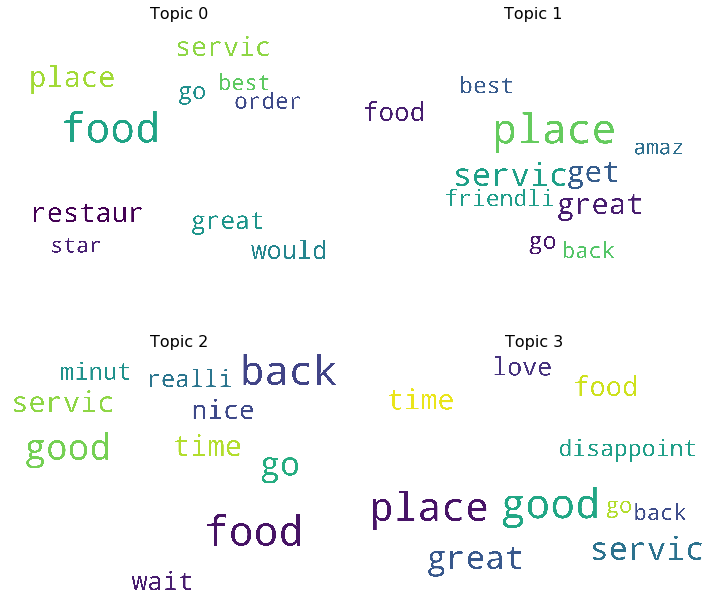

In [39]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=nltk.corpus.stopwords.words('english'),
                  background_color='white',
                  width=2500,
                  height=1800,
                 max_words=10,
                prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)
#print(topics[1][1][1][1])
fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])

    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    print(topic_words.keys)
    #plt.bar(x = topic_words.keys , y = topic_words.values)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
#plt.axis('off')
plt.margins(x=1, y=1)
plt.tight_layout()
plt.show()

    
print(topic_words)